<table width="100%" border="0">
  <tr>    
  <td><img src="./images/ing.png" alt="" align="left" /></td>
  <td><img src="./images/ucv.png" alt="" align="center" height="100" width="100" /></td>
  <td><img src="./images/mec.png" alt="" align="right"/></td>
  </tr>
</table>

<br>

<h1 style="text-align: center;"> Curso de Python para Ingenieros Mecánicos </h1> 
<h3 style="text-align: center;"> Por: Eduardo Vieira</h3>
<br>
<br>
<h1 style="text-align: center;">  Numba - Acelerar código Python </h1> 
<br>

# Cómo acelerar Python usando numba

_En ocasiones nos encontraremos con algoritmos que no serán fácilmente vectorizables o expresables en operaciones sobre arrays de NumPy, y sufriremos los problemas de rendimiento de Python. En este notebook vamos a hacer un repaso exhaustivo de **cómo acelerar sustancialmente nuestro código Python usando numba**. Esta clase está basada en el artículo http://pybonacci.org/2015/03/13/como-acelerar-tu-codigo-python-con-numba/ _

## ¿Qué es numba?

numba es un compilador JIT (_just-in-time_) de Python que genera código máquina para CPU o GPU utilizando la infraestructura LLVM especializado en aplicaciones numéricas. Vamos a ver un ejemplo muy básico de cómo funciona:

In [32]:
import numpy as np
from numba import njit

In [33]:
arr2d = np.arange(20 * 30, dtype=float).reshape(20,30)

In [34]:
%%timeit
np.sum(arr2d)

9.03 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
def py_sum(arr):
    M, N = arr.shape
    sum = 0.0
    for i in range(M):
        for j in range(N):
            sum += arr[i,j]
    return sum

In [36]:
%%timeit
py_sum(arr2d)

209 µs ± 40.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
fast_sum = njit(py_sum)

In [38]:
%%timeit -n1 -r1
fast_sum(arr2d)

101 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [39]:
%%timeit
fast_sum(arr2d)

1.12 µs ± 33.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


¿Impresionado? La primera vez que hemos llamado a la función, Python ha generado el código correspondiente al tipo de datos que le hemos pasado. Podemos verlo aquí:

In [40]:
fast_sum.signatures

[(array(float64, 2d, C),)]

E imprimir el código generado así:

In [41]:
fast_sum.inspect_types()

py_sum (array(float64, 2d, C),)
--------------------------------------------------------------------------------
# File: <ipython-input-35-ea571924c8ab>
# --- LINE 1 --- 
# label 0
#   del $0.2
#   del $0.5
#   del $0.3
#   del $0.4
#   del $const0.6

def py_sum(arr):

    # --- LINE 2 --- 
    #   arr = arg(0, name=arr)  :: array(float64, 2d, C)
    #   $0.2 = getattr(value=arr, attr=shape)  :: (int64 x 2)
    #   $0.5 = exhaust_iter(value=$0.2, count=2)  :: (int64 x 2)
    #   $0.3 = static_getitem(value=$0.5, index=0, index_var=None)  :: int64
    #   $0.4 = static_getitem(value=$0.5, index=1, index_var=None)  :: int64
    #   M = $0.3  :: int64
    #   N = $0.4  :: int64

    M, N = arr.shape

    # --- LINE 3 --- 
    #   $const0.6 = const(float, 0.0)  :: float64
    #   sum = $const0.6  :: float64
    #   jump 14
    # label 14

    sum = 0.0

    # --- LINE 4 --- 
    #   jump 16
    # label 16
    #   $16.1 = global(range: <class 'range'>)  :: Function(<class 'range'>)
    #   

## Entendiendo numba: el modo *nopython*

Como podemos leer en la documentación, [numba tiene dos modos de funcionamiento básicos](http://numba.pydata.org/numba-doc/0.17.0/user/jit.html#nopython): el modo *object* y el modo *nopython*.

* El modo *object* genera código que gestiona todas las variables como objetos de Python y utiliza la API C de Python para operar con ellas. En general en este modo **no habrá ganancias de rendimiento** (e incluso puede ir más lento), con lo cual mi recomendación personal es directamente no utilizarlo. Hay casos en los que numba puede detectar los bucles y optimizarlos individualmente (*loop-jitting*), pero no le voy a prestar mucha atención a esto.
* El modo *nopython* **genera código independiente de la API C de Python**. Esto tiene la desventaja de que no podemos usar todas las características del lenguaje, **pero tiene un efecto significativo en el rendimiento**. Otra de las restricciones es que **no se puede reservar memoria para objetos nuevos**.

Por defecto numba usa el modo *nopython* siempre que puede, y si no pasa a modo *object*. Nosotros vamos a **forzar el modo nopython** (o «modo estricto» como me gusta llamarlo) porque es la única forma de aprovechar el potencial de numba.

## Ámbito de aplicación

El problema del modo *nopython* es que los mensajes de error son totalmente inservibles en la mayoría de los casos, así que antes de lanzarnos a compilar funciones con numba conviene hacer un repaso de qué no podemos hacer para anticipar la mejor forma de programar nuestro código. Podéis consultar en la documentación [el subconjunto de Python soportado por numba](http://numba.pydata.org/numba-doc/0.17.0/reference/pysupported.html) en modo *nopython*, y ya os aviso que, al menos de momento, no tenemos [*list comprehensions*](https://github.com/numba/numba/issues/504), [delegación de generadores](https://github.com/numba/numba/issues/984) ni algunas cosas más. Permitidme que resalte una frase sacada de la página principal de numba:

> "*With a few annotations, **array-oriented and math-heavy Python code** can be just-in-time compiled to native machine instructions, similar in performance to C, C++ and Fortran*". [Énfasis mío]

Siento decepcionar a la audiencia pero *numba no acelerará todo el código Python* que le echemos: está enfocado a operaciones matemáticas con arrays. Aclarado este punto, vamos a ponernos manos a la obra con un ejemplo aplicado :)

## Acelerando una función con numba

Vamos a intentar acelerar la siguiente función, tomada del artículo http://pybonacci.org/2015/03/09/c-elemental-querido-cython/:

> "Por ejemplo, imaginemos que tenemos que detectar valores mínimos locales dentro de una malla. Los valores mínimos deberán ser simplemente valores más bajos que los que haya en los 8 nodos de su entorno inmediato. En el siguiente gráfico, el nodo en verde será un nodo con un mínimo y en su entorno son todo valores superiores:

<table>
 <tr>
  <td style="background:red">(2, 0)</td>
  <td style="background:red">(2, 1)</td>
  <td style="background:red">(2, 2)</td>
 </tr>
 <tr>
  <td style="background:red">(1, 0)</td>
  <td style="background:green">(1. 1)</td>
  <td style="background:red">(1, 2)</td>
 </tr>
 <tr>
  <td style="background:red">(0, 0)</td>
  <td style="background:red">(0, 1)</td>
  <td style="background:red">(0, 2)</td>
 </tr>
</table>

Creamos nuestro array de datos:

In [42]:
data = np.random.randn(2000, 2000)

Y copiemos directamente la función original:

In [43]:
def busca_min(malla):
    minimosx = []
    minimosy = []
    for i in range(1, malla.shape[1]-1):
        for j in range(1, malla.shape[0]-1):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

In [44]:
busca_min(data)

(array([   1,    1,    1, ..., 1998, 1998, 1998]),
 array([  16,   22,   24, ..., 1948, 1950, 1955]))

### Paso 0: Analizar el rendimiento

Guía sobre cómo analizar el rendimiento en Python: https://www.huyng.com/posts/python-performance-analysis

In [45]:
%%timeit
busca_min(data)

5.11 s ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
stats = %prun -s cumtime -rq busca_min(data)
stats.print_stats()

          887046 function calls in 5.213 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    5.213    5.213 {built-in method builtins.exec}
        1    0.010    0.010    5.213    5.213 <string>:1(<module>)
        1    5.054    5.054    5.204    5.204 <ipython-input-43-08c7a5f9247e>:1(busca_min)
        2    0.075    0.038    0.075    0.038 {built-in method numpy.core.multiarray.array}
   887040    0.075    0.000    0.075    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Parece que está habiendo demasiadas llamadas a `list.append`, aunque representan un porcentaje pequeño del tiempo de ejecución.

Para instalar `line_profiler`:

`conda install -c anaconda line_profiler`

In [48]:
%load_ext line_profiler

In [49]:
stats = %lprun -f busca_min -r busca_min(data)
stats.print_stats()

Timer unit: 1e-06 s

Total time: 16.3911 s
File: <ipython-input-43-08c7a5f9247e>
Function: busca_min at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def busca_min(malla):
     2         1            3      3.0      0.0      minimosx = []
     3         1            1      1.0      0.0      minimosy = []
     4      1999         1491      0.7      0.0      for i in range(1, malla.shape[1]-1):
     5   3994002      2599135      0.7     15.9          for j in range(1, malla.shape[0]-1):
     6   3992004      5030736      1.3     30.7              if (malla[j, i] < malla[j-1, i-1] and
     7   1996000      2293512      1.1     14.0                  malla[j, i] < malla[j-1, i] and
     8   1330587      1572819      1.2      9.6                  malla[j, i] < malla[j-1, i+1] and
     9    997985      1143906      1.1      7.0                  malla[j, i] < malla[j, i-1] and
    10    798233       910484      1.1      

### Paso 1: Mejorar el algoritmo

Hacer `append` a esas dos listas tantas veces no parece una buena idea. De hecho, se puede comprobar que se hace para un porcentaje significativo de los elementos:

In [50]:
mx, my = busca_min(data)
mx.size / data.size

0.11088

Tenemos que más de un 10 % de los elementos de la matriz cumplen la condición de ser «mínimos locales», así que no es nada despreciable. Esto en nuestro ejemplo hace *un total de más de 400 000 elementos*:

In [51]:
mx.size

443520

En lugar de esto, lo que vamos a hacer va a ser crear otro array, de la misma forma que nuestros datos, y almacenar un valor `True` en aquellos elementos que cumplan la condición de mínimo local. De esta forma cumplimos también una de las reglas de oro de Software Carpentry: "*Always initialize from data*".

In [52]:
def busca_min_np(malla):
    minimos = np.zeros_like(malla, dtype=bool)
    for i in range(1, malla.shape[1]-1):
        for j in range(1, malla.shape[0]-1):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimos[i, j] = True

    return np.nonzero(minimos)

Encima puedo aprovechar la estupenda función `nonzero` de NumPy. Compruebo que las salidas son iguales:

In [53]:
np.testing.assert_array_equal(busca_min(data)[0], busca_min_np(data)[0])
np.testing.assert_array_equal(busca_min(data)[1], busca_min_np(data)[1])

Y evalúo el rendimiento de la nueva función:

In [54]:
%timeit busca_min_np(data)

5.25 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Como era de esperar**, los tiempos son parecidos, porque no he optimizado el cuello de botella que son las comprobaciones de los arrays. Al menos, ya no tenemos dos objetos en memoria que van a crecer de manera aleatoria: ya podemos utilizar numba.

### Paso 2: Aplicar `numba.jit(nopython=True)`

Como hemos dicho antes, vamos a forzar que numba funcione en modo *nopython* para garantizar que obtenemos una mejora en el rendimiento. Si intentamos compilar la primera función, ya vamos a ver una ganancia de rendimiento sustancial:

In [55]:
busca_min_jit = njit(busca_min)
busca_min_jit(data)

(array([   1,    1,    1, ..., 1998, 1998, 1998]),
 array([  16,   22,   24, ..., 1948, 1950, 1955]))

In [56]:
%timeit busca_min_jit(data)

117 ms ± 599 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


¿Qué pasa si hacemos lo mismo con la versión que no utiliza listas?

In [57]:
busca_min_np_jit = njit(busca_min_np)
busca_min_np_jit(data)

TypingError: Failed at nopython (nopython frontend)
Invalid usage of Function(<function zeros_like at 0x7f5320147620>) with parameters (array(float64, 2d, C), dtype=Function(<class 'bool'>))
 * parameterized
File "<ipython-input-52-c316e0a5a386>", line 2
[1] During: resolving callee type: Function(<function zeros_like at 0x7f5320147620>)
[2] During: typing of call at <ipython-input-52-c316e0a5a386> (2)

Obtenemos un error porque numba no reconoce la función `np.zeros_like` con los argumentos que le hemos pasado. Si acudimos a la documentación http://numba.pydata.org/numba-doc/0.31.0/reference/numpysupported.html#other-functions, vemos que hay que utilizar tipos de NumPy, en este caso `np.bool_`.

In [58]:
@njit
def busca_min_np2_jit(malla):
    minimos = np.zeros_like(malla, np.bool_)  # <-- Cambiar esta línea
    for i in range(1, malla.shape[1]-1):
        for j in range(1, malla.shape[0]-1):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimos[i, j] = True

    return np.nonzero(minimos)

busca_min_np2_jit(data)

(array([   1,    1,    1, ..., 1998, 1998, 1998]),
 array([  16,   22,   24, ..., 1948, 1950, 1955]))

In [59]:
%timeit busca_min_np2_jit(data)

69.3 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Lo hemos conseguido: **70x más rápido** :)

## Ejercicios

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import sin, pi

### La atmósfera estándar

El **cálculo de propiedades termodinámicas de la atmósfera estándar** es un problema clásico que todo aeronáutico ha afrontado alguna vez muy al principio de su carrera formativa. La teoría es simple: imponemos una ley de variación de la temperatura con la altura $T = T(h)$, la presión se obtiene por consideraciones hidrostáticas $p = p(T)$ y la densidad por la ecuación de los gases ideales $\rho = \rho(p, T)$. La particularidad de la atmósfera estándar es que imponemos que la variación de la temperatura con la altura es una función simplificada *y definida a trozos*, así que calcular temperatura, presión y densidad dada una altura se parece mucho a hacer esto:

$$T(h) = \begin{cases} T_0 + \alpha h & 0 <= h <= 11000 \\ T(11000) & 11000 < h <= 20000 \end{cases}
\\ ~\\ T_0 = 288.16 K \\
\alpha = -6.5 \cdot 10^{-3}~\text{K/m}$$

$$ \rho(h) = \begin{cases} \rho_0 \left( \frac{T}{T_0} \right)^{-\frac{g}{\alpha R} - 1} & 0 <= h <= 11000 \\ \rho(11000)~e^{\frac{-g(z - 11000)}{R T}} & 11000 < h <= 20000 \end{cases} $$

$$\rho_0 = 1.225~\text{[SI]} \\
R = 287~\text{[SI]}$$

$$p = \rho R_a T$$

```python
if 0.0 <= h < 11000.0:
    T = T0 + alpha * h
    rho = ...  # Algo que depende de T
    p = rho * R_a * T
elif 11000.0 <= h < 20000.0:
    T = T1
    rho = ...
    p = rho * R_a * T
```

El problema viene cuando se quiere **vectorizar** esta función y permitir que `h` pueda ser un array de alturas. Esto es muy conveniente cuando queremos pintar alguna propiedad con matplotlib, por ejemplo.

Se intuye que hay dos formas de hacer esto: utilizando funciones de NumPy o iterando por cada elemento del array.

In [61]:
# Constants
R_a = 287.05287  # J/(Kg·K)
g0 = 9.80665  # m/s^2
T0 = 288.15  # K
p0 = 101325.0  # Pa

alpha = np.array([-6.5e-3, 0.0])  # K / m

# Computed constants
T1 = T0 + alpha[0] * 11000.0
p1 = p0 * (T0 / (T0 + alpha[0] * 11000.0)) ** (g0 / (R_a * alpha[0]))


def atm(h):
    """Standard atmosphere temperature, pressure and density.
    Parameters
    ----------
    h : array-like
        Geopotential altitude, m.
    """
    h = np.atleast_1d(h).astype(float)
    scalar = (h.size == 1)
    assert len(h.shape) == 1
    T = np.empty_like(h)
    p = np.empty_like(h)
    rho = np.empty_like(h)

    # Actually compute the values
    _atm(h, T, p, rho)

    if scalar:
        T = T[0]
        p = p[0]
        rho = rho[0]

    return T, p, rho


@njit
def _atm(h, T, p, rho):
    for ii in range(h.size):
        if 0.0 <= h[ii] < 11000.0:
            T[ii] = T0 + alpha[0] * h[ii]
            p[ii] = p0 * (T0 / (T0 + alpha[0] * h[ii])) ** (g0 / (R_a * alpha[0]))
            rho[ii] = p[ii] / (R_a * T[ii])
        elif 11000.0 <= h[ii] <= 20000.0:
            T[ii] = T1  #  + alpha[1] * (h[ii] - 11000.0)
            p[ii] = p1 * np.exp(-g0 * (h[ii] - 11000.0) / (R_a * T1))
            rho[ii] = p[ii] / (R_a * T[ii])

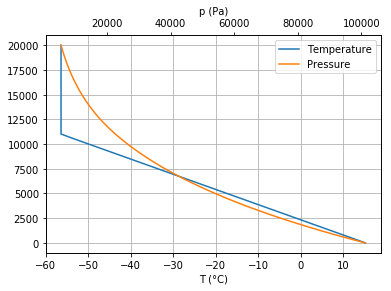

In [62]:
# aeropython: preserve
h = np.linspace(0, 20000)
T, p, _ = atm(h)

fig, ax1 = plt.subplots()

l1, = ax1.plot(T - 273, h, color="C0")
ax1.set_xlabel("T (°C)")

ax2 = ax1.twiny()
l2, = ax2.plot(p, h, color="C1")
ax2.set_xlabel("p (Pa)")

ax1.legend((l1, l2), ["Temperature", "Pressure"], loc=0)
ax1.grid()

## Solución de Navier de una placa plana

Implementar y representar gráficamente la solución de Navier para calcular la deflexión de una placa rectangular, simplemente apoyada en sus cuatro bordes (es decir, los bordes pueden girar: no están empotrados) sometida a una carga transversal. La expresión matemática es:

$$w(x,y) = \sum_{m=1}^\infty \sum_{n=1}^\infty \frac{a_{mn}}{\pi^4 D}\,\left(\frac{m^2}{a^2}+\frac{n^2}{b^2}\right)^{-2}\,\sin\frac{m \pi x}{a}\sin\frac{n \pi y}{b}$$

siendo $a_{mn}$ los coeficientes de Fourier de la carga aplicada.

Para cada punto $(x, y)$ hay que hacer una doble suma en serie; si además queremos evaluar esto en un `meshgrid`, necesitamos **un cuádruple bucle**.

In [63]:
@njit
def a_mn_point(P, a, b, xi, eta, mm, nn):
    """Navier series coefficient for concentrated load.

    """
    return 4 * P * sin(mm * pi * xi / a) * sin(nn * pi * eta / b) / (a * b)
 
 
@njit
def plate_displacement(xx, yy, ww, a, b, P, xi, eta, D, max_m, max_n):
    max_i, max_j = ww.shape
    for mm in range(1, max_m):
        for nn in range(1, max_n):
            for ii in range(max_i):
                for jj in range(max_j):
                    a_mn = a_mn_point(P, a, b, xi, eta, mm, nn)
                    ww[ii, jj] += (a_mn / (mm**2 / a**2 + nn**2 / b**2)**2
                                   * sin(mm * pi * xx[ii, jj] / a)
                                   * sin(nn * pi * yy[ii, jj] / b)
                                   / (pi**4 * D)) 

Maximum displacement = 0.101508051672 mm
alpha = 0.00831
alpha * P a^2 / D = 0.1416 mm


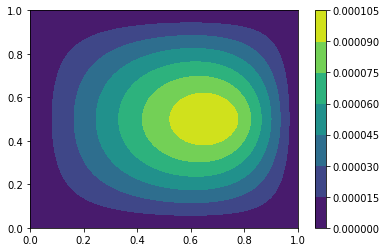

In [64]:
# aeropython: preserve
# Plate geometry
a = 1.0  # m
b = 1.0  # m
h = 50e-3  # m

# Material properties
E = 69e9  # Pa
nu = 0.35

# Series terms
max_m = 16
max_n = 16

# Computation points
# NOTE: With an odd number of points the center of the place is included in
# the grid
NUM_POINTS = 101

# Load
P = 10e3  # N
xi = 3 * a / 4
eta = a / 2

# Flexural rigidity
D = h**3 * E / (12 * (1 - nu**2))

# ---

# Set up domain
x = np.linspace(0, a, num=NUM_POINTS)
y = np.linspace(0, b, num=NUM_POINTS)
xx, yy = np.meshgrid(x, y)

# Compute displacement field
ww = np.zeros_like(xx)
plate_displacement(xx, yy, ww, a, b, P, xi, eta, D, max_m, max_n)

# Print maximum displacement
w_max = abs(ww).max()
print("Maximum displacement = %14.12f mm" % (w_max * 1e3))
print("alpha = %7.5f" % (w_max / (P * a**2 / D)))
print("alpha * P a^2 / D = %6.4f mm" % (0.01160 * P * a**2 / D * 1e3))

plt.contourf(xx, yy, ww)
plt.colorbar()

In [65]:
# Esta celda da el estilo al notebook
from IPython.core.display import HTML
css_file = './css/aeropython.css'
HTML(open(css_file, "r").read())